# TODO ITEMS

1. Possibly change loss weighting on adversarial vs. content in generator loss function

DONE:

1. Normalize input to be in [0, 1], which Ledig's paper does and looks like GAN HW also put input into [-1, 1]
2. Normalize high res images to also be in [-1, 1], which is what Ledig's paper also does


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import h5py

from time import time

/Users/antarikshmahajan/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cpu


In [5]:
# Adapted from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py# Adapt 

HEIGHT_INDEX = 200
WIDTH_INDEX = 200

IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS_IN = 3
NUM_CHANNELS_OUT = 2

TRAIN_FILES = 1
VAL_FILES = 0
TEST_FILES = 0
YEARS_PER_FILE = 10
IMGS_PER_YEAR = 365

class SR_Dataset(data.Dataset):
    """
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    base_folder = 'sr_data'
    elevation_file = 'dem.pkl'
    
    train_list = np.array([
        '1950s.hdf5',
#         '1960s.hdf5',
#         '1970s.hdf5'
    ])
    
    val_list = np.array([
        
    ])

    test_list = np.array([
        
    ])

    def __init__(self, root, train=True):
        
        self.root = os.path.expanduser(root)
        self.train = train  # training set or test set
        
        # load elevation data
        fo_in = open(os.path.join(self.root, self.elevation_file), 'rb')
        self.elevation = pickle.load(fo_in)
        fo_in.close()
        elev_mean = np.mean(self.elevation)
        elev_var = np.var(self.elevation)
        self.elevation = (self.elevation - elev_mean) / np.sqrt(elev_var)
        h,w = self.elevation.shape
        self.elevation = self.elevation.reshape((1,h,w))

    in_mean = np.array([1.9028055e-05, 284.676482])
    in_var = np.array([1.5503707e-09, 108.102618])
    out_mean = np.array([1.902273e-05, 284.676482])
    out_var = np.array([2.3926674e-09, 108.102618])
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (low_res, high_res)
        """
        t1 = time()
        file_idx = index // (YEARS_PER_FILE * IMGS_PER_YEAR)
        img_in_file = index % (YEARS_PER_FILE * IMGS_PER_YEAR)
        year_idx = img_in_file // IMGS_PER_YEAR
        idx_in_year = img_in_file % IMGS_PER_YEAR
        
        f = None
        if self.train:
            f = h5py.File(os.path.join(self.base_folder, self.train_list[file_idx]), 'r')
        else:
            f = h5py.File(os.path.join(self.base_folder, self.val_list[file_idx]), 'r')
        
        yr = list(f.keys())[year_idx]
        pr =  f[yr]['pr'][idx_in_year]
        tas = f[yr]['tas'][idx_in_year]
        f.close()
        high_res = np.flip(np.concatenate((pr[np.newaxis,:,:], tas[np.newaxis,:,:])),axis=1)
        
        # Now crop the high_res as soon as we get it
        high_res = high_res[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]
        #
        # TODO: once we pick a permanent crop, crop the elevation there so we don't have to do it every time
        #
        # Also crop the elevation data to the same place, then sample it to make it the same shape as 
        # lowres is going to be so that it can be concatenated onto it
        elev_crop = self.elevation[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]
        elev_crop = elev_crop[:, ::2, ::2]

        # get the input LR image from output HR image
        c,h1,w1 = high_res.shape
        blurred = np.zeros_like(high_res)
#         for i in range(c):
#             blurred[i,:,:] = gaussian_filter(high_res[i,:,:], 0.55)
#         half_res = blurred[:, ::2, ::2]
        blurred = gaussian_filter(high_res, sigma = (0, 0.55, 0.55))
        low_res = blurred[:, ::2, ::2]
        
        # Code involved in interpolating the blurred image back up to high res resolution
#         c,h2,w2 = half_res.shape
#         x = np.arange(h2)
#         y = np.arange(w2)
#         xnew = np.arange(0, h2, h2/h1)
#         ynew = np.arange(0, w2, w2/w1)
#         low_res = np.zeros_like(high_res)
#         for i in range(c):
#             f = RectBivariateSpline(x, y, half_res[i, :, :])
#             low_res[i, :, :] = f(xnew, ynew)
            
        low_res =  (low_res -  self.in_mean[:,np.newaxis,np.newaxis])  / np.sqrt(self.in_var[:,np.newaxis,np.newaxis])
        high_res = (high_res - self.out_mean[:,np.newaxis,np.newaxis]) / np.sqrt(self.out_var[:,np.newaxis,np.newaxis])
        
        low_res = np.concatenate((low_res, elev_crop))
        
        
        
        #######################################################################################################
        # SET THE RANGE OF TRAIN DATA FROM 0 TO 1, RANGE OF HIGH RES DATA TO -1 TO 1, as they do in Ledig
        #######################################################################################################
#         low_res -= np.amin(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
#         low_res /= np.amax(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        
        low_min = np.amin(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        low_max = np.amax(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        low_res = (low_res - low_min) / (low_max - low_min)
#         high_res -= np.amin(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
#         high_res /= np.amax(high_res, axis=(1,2))[:, np.newaxis, np.newaxis] / 2
#         high_res -= 1
        
        high_min = np.amin(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_max = np.amax(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_res = (high_res - high_min) / ((high_max - high_min) / 2)
        # Gotta cast the lowres to float (from double) else it confuses the model, since model's standard
        # is to assume float
        low_res = torch.from_numpy(low_res).float() 
        high_res = torch.from_numpy(high_res).float()
        
        
        #print(time()-t1)
        return low_res, high_res

    def __len__(self):
        if self.train:
            return len(self.train_in)
        else:
            return len(self.test_in)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [6]:
data_directory = '.'

BATCH_SIZE = 250

sr_train = SR_Dataset(data_directory, train=True)
loader_train = DataLoader(sr_train, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

#sr_val = SR_Dataset(data_directory, train=True, transform=transform, target_transform=transform)
#loader_val = DataLoader(sr_val, batch_size=batch_size, 
#                        sampler=sampler.SubsetRandomSampler(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE)))

#sr_test = SR_Dataset(data_directory, train=True, transform=transform)
#loader_test = DataLoader(sr_test, batch_size=batch_size)

In [8]:
testx, testy = sr_train.__getitem__(3)
torch.min(testx)
# torch.max(testx)
# torch.min(testy)
# torch.max(testy)


tensor(0.)

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
#         print("Flatten input: ", x.shape)
        N, C, H, W = x.size() # read in N, C, H, W
#         print("Flatten output: ", x.view(N, -1).shape)
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [10]:
def bce_loss(input, target):
    """
    Taken from the homework GAN notebook. This is a helper function to be used in the loss functions of D and G
    
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs().to(device=device)
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [11]:
def discriminator_loss(logits_real, logits_fake):
    """
    
    Taken from homework 3, GAN notebook
    
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data (real numbers). 
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data (real numbers).
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    N = logits_real.shape[0]
    real_labels = torch.ones(N).to(device=device, dtype=dtype)
    L1 = bce_loss(logits_real, real_labels)
    
    fake_labels = torch.zeros(N).to(device=device, dtype=dtype)
    L2 = bce_loss(logits_fake, fake_labels)
    
    loss = (L1 + L2)
    return loss

In [12]:
def generator_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Content loss - MSE loss for now. Ludig paper also suggests using
    # Euclidean distance between feature vector of true image and generated image, 
    # where we get the feature vector from a pretrained VGGnet. Probably wouldn't
    # work for us (at least pretrained) because climate data looks so different from normal pictures
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N).to(device=device, dtype=dtype)
    adversarial_loss = bce_loss(logits_fake, desired_labels)
    return content_loss + weight_param*adversarial_loss
    
    

In [13]:
def get_optimizer(model):
    """
    Copied from homework GAN notebook since I'll copy their training function too anyways
    
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

In [14]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, H, W):
        super().__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            Flatten(),
            nn.Linear(512*np.ceil(H/16)*np.ceil(W/16), 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
            

            # For the last layer, this is what was originally in the code I used as reference. 
            # I think he's just doing a strange way of flattening the data
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(512, 1024, kernel_size=1),
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(1024, 1, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        return x + self.layers(x)

class UpscaleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(64, 256, 3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.PReLU()
        )
    
    def forward(self, x):
        return self.layers(x)
        

#######################################################################################################
#   DO I NEED TO TURN BATCHNORM OFF AT TEST TIME TO COPY PAPER OR DOES PYTORCH DO THAT AUTOMATICALLY??
#######################################################################################################

class Generator(nn.Module):
    def __init__(self, num_channels, num_res_blocks=16, scale_factor=2):
#         upsample_block_num = int(math.log(scale_factor, 2))

        super().__init__()
    
        self.num_res_blocks = num_res_blocks
        self.initial_conv = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        self.resBlocks = [ResidualBlock(64) for i in range(self.num_res_blocks)]
#         self.block2 = ResidualBlock(64)
#         self.block3 = ResidualBlock(64)
#         self.block4 = ResidualBlock(64)
#         self.block5 = ResidualBlock(64)
#         self.block6 = ResidualBlock(64)
        
        # Block from dude's original code, doesn't make sense to me though because it's missing stuff
#         self.block7 = nn.Sequential(    
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.PReLU()
#         )

        self.post_resid_conv = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

#         block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
#         block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
#         self.block8 = nn.Sequential(*block8)
        
#         # Block that performs the upscaling by 2x (done in the PixelShuffle layer)
#         self.upscale_conv = nn.Sequential(
#             nn.Conv2d(64, 256, 3, stride=1, padding=1),
#             nn.PixelShuffle(upscale_factor=2),
#             nn.PReLU()
#         )
    
#         # THIS BLOCK IS IF YOU WANT TO UPSCALE AN ADDITIONAL 2X
# #         self.block9 = nn.Sequential(
# #             nn.Conv2d(64, 256, 3, stride=1, padding=1),
# #             nn.PixelShuffle(upscale_factor=2),
# #             nn.PReLU()
# #         )
        self.num_upscale_blocks = scale_factor // 2
        self.upscaleBlocks = [UpscaleBlock() for i in range(self.num_upscale_blocks)]
        
        self.final_conv = nn.Conv2d(64, 2, 9, stride=1, padding=4)


    def forward(self, x):
        initial_conv_out = self.initial_conv(x)
        res_block_out = self.resBlocks[0](initial_conv_out)
        for i in range(1, self.num_res_blocks):
            res_block_out = self.resBlocks[i](res_block_out)
        post_resid_conv_out = self.post_resid_conv(res_block_out) + initial_conv_out
        if self.num_upscale_blocks > 0:  
            upscale_out = self.upscaleBlocks[0](post_resid_conv_out)
            for i in range(1, self.num_upscale_blocks):
                upscale_out = self.upscaleBlocks[i](upscale_out)
    #         block7_out = self.block7(res_block_out)
#             block8_out = self.block8(block1_out + block7_out)
        # Remove block 9, since it upsamples it a second time and we don't want that
#         block9_out = self.block9(block8_out) 
        final_out = self.final_conv(upscale_out)

        return F.tanh(final_out) 
#         return F.tanh(block10_out)  
#         return (F.tanh(block8) + 1) / 2

-0.47637963


/Users/antarikshmahajan/.env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


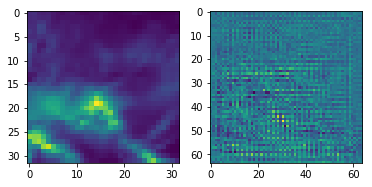

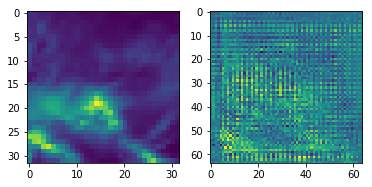

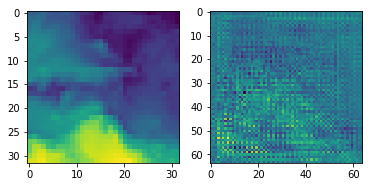

In [19]:
def test_Generator():
    h = 32
    w = h
#     x = torch.zeros((1, NUM_CHANNELS_IN, h, w), dtype=dtype)  # minibatch size 64, feature dimension 50
    x = (sr_train.__getitem__(3)[0]).unsqueeze_(0)
    model = Generator(NUM_CHANNELS_IN, scale_factor=2)
    model = model.to(device=device)
    x = x.to(device=device, dtype=dtype)
    output = model(x)
    print(np.amin(output[0,1,:,:].detach().numpy()))
    plt.subplot(121)
    plt.imshow(x.detach().numpy()[0, 0, :, :])
    plt.subplot(122)
    plt.imshow(output.detach().numpy()[0, 0, :, :])
    plt.figure()
    plt.subplot(121)
    plt.imshow(x.detach().numpy()[0, 1, :, :])
    plt.subplot(122)
    plt.imshow(output.detach().numpy()[0, 1, :, :])
    plt.show()
test_Generator()

In [20]:
def test_Discriminator():
    h = 65
    w = h
    x = torch.zeros((1, NUM_CHANNELS_IN, h, w), dtype=dtype)  # minibatch size 64, feature dimension 50
    print("x: ", x.shape)
    model = Discriminator(NUM_CHANNELS_IN, h, w)
    output = model(x)
    print(output.size())
    print(output)
test_Discriminator()

x:  torch.Size([1, 3, 65, 65])
torch.Size([1, 1])
tensor([[ 0.4739]])


In [21]:
def plot_epoch(x, y_pred, y):
    plt.figure(figsize=(16,12))
    plt.subplot(2,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.title("Lowres Precip (Input)")
    plt.subplot(2,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.title("Generated Precip (Output)")
    plt.subplot(2,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.title("Highres Precip (True)")
    plt.subplot(2,3,4)
    plt.imshow(x[0,1,:,:].cpu().detach().numpy())
    plt.title("Lowres Temp (Input)")
    plt.subplot(2,3,5)
    plt.imshow(y_pred[0,1,:,:].cpu().detach().numpy())
    plt.title("Generated Temp (Output)")
    plt.subplot(2,3,6)
    plt.imshow(y[0,1,:,:].cpu().detach().numpy())
    plt.title("Highres Temp (True)")
    plt.show()

In [23]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, num_epochs=5):
    """
    FROM THE HOMEWORK
    
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    # Move the models to the correct device (GPU if GPU is available)
    D = D.to(device=device)
    G = G.to(device=device)
    
#     D_loss_history = np.zeros(len(loader_train)*)
    
    
    # Put the models in training mode?
    
    iter_count = 0
    for epoch in range(num_epochs):
        for x,y in loader_train:
#             if len(x) != batch_size:
#                 print("Something about len(x) != batch_size")
#                 continue
                
            # Update for the discriminator
            D_solver.zero_grad()
            high_res_imgs = y.to(device=device, dtype=dtype)
            logits_real = D(high_res_imgs).to(device=device, dtype=dtype)

            low_res_imgs = x.to(device=device, dtype=dtype)
            fake_images = G(low_res_imgs).detach()
#             logits_fake = D(fake_images.view(batch_size, 1, 28, 28))   # Not sure why there's the view() call..
            logits_fake = D(fake_images)
    
            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            # Update for the generator
            G_solver.zero_grad()

#             gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            gen_logits_fake = D(fake_images)
            g_error = generator_loss(fake_images, high_res_imgs, gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                plot_epoch(x, fake_images, y)
                print()
            iter_count += 1

In [24]:
D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=20)

Process Process-4:
Process Process-1:
Process Process-3:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/antarikshmahajan/.env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/queues.py",

KeyboardInterrupt: 

In [8]:
def train_it(optimizer, model, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            y_predicted = model(x)
            loss_func = nn.MSELoss()
            loss = loss_func(y_predicted, y)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][0].detach().numpy())
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][0].detach().numpy())
                plt.subplot(1,3,3)
                plt.imshow(y[0][0].detach().numpy())
                plt.show()
                
                #check_accuracy(loader_val, model)
                
            del x, y, loss

Iteration 0, loss = 0.0137


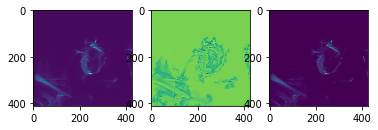

Iteration 1, loss = 0.0132


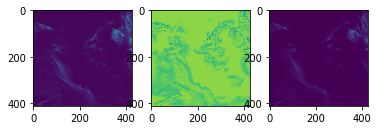

In [ ]:
learning_rate = 1e-4

model = SRCNN(1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_it(optimizer, model)